In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import concurrent.futures
from enum import Enum
from tqdm import tqdm
from pyDOE import lhs
from datetime import datetime
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create output directories
output_dir = './outputs'
models_dir = os.path.join(output_dir, 'models')
plots_dir = os.path.join(output_dir, 'plots')
videos_dir = os.path.join(output_dir, 'videos')

os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(videos_dir, exist_ok=True)

# %% [markdown]
# ## 2. Simulation and Visualization Classes

# %%
class PlotType(Enum):
    REAL       = "real"
    IMAG       = "imag"
    ABS        = "abs"
    ANGLE      = "angle"
    REAL_IMAG  = "real_imag"
    UNCHANGED  = "unchanged"
    ABS_SQUARE = "abs_square"

class PlotBuilder:
    def __init__(self):
        self.fig, self.axes = None, None
        self.plots = []

    def set_grid(self, rows, cols):
        self.fig, self.axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
        self.axes = self.axes.flatten() if rows * cols > 1 else [self.axes]
        return self

    def add_plot(self, index, data, plot_type=PlotType.UNCHANGED, **kwargs):
        if self.fig is None or self.axes is None:
            raise ValueError("Grid is not set. Use set_grid(rows, cols) first.")

        if index >= len(self.axes):
            raise IndexError("Index exceeds the number of grid cells.")

        ax = self.axes[index]
        image_kwargs = {k: v for k, v in kwargs.items() if k not in ["xlabel", "ylabel", "title", "colorbar", "annotations"]}
        img = self._generate_image(ax, data, plot_type, **image_kwargs)

        self._apply_axes_settings(ax, **kwargs)
        self._apply_special_settings(ax, img, **kwargs)

        self.plots.append((index, data, plot_type, kwargs))
        return self

    def _generate_image(self, ax, data, plot_type, **kwargs):
        plot_actions = {
            PlotType.UNCHANGED:  lambda: ax.imshow(data, **kwargs),
            PlotType.REAL:       lambda: ax.imshow(data.real, **kwargs),
            PlotType.IMAG:       lambda: ax.imshow(data.imag, **kwargs),
            PlotType.ABS:        lambda: ax.imshow(np.abs(data), **kwargs),
            PlotType.ANGLE:      lambda: ax.imshow(np.angle(data), **kwargs),
            PlotType.REAL_IMAG:  lambda: ax.imshow(data.imag * data.real, **kwargs),
            PlotType.ABS_SQUARE: lambda: ax.imshow(np.abs(data) ** 2, **kwargs)
        }

        if plot_type not in plot_actions:
            valid_types = ", ".join([pt.value for pt in PlotType])
            raise ValueError(f"Unsupported plot_type. Use PlotType enum values: {valid_types}.")

        return plot_actions[plot_type]()

    def _apply_axes_settings(self, ax, **kwargs):
        for key, value in kwargs.items():
            if key in ["xlabel", "ylabel", "title"]:
                getattr(ax, f"set_{key}")(value)

    def _apply_special_settings(self, ax, img, **kwargs):
        if "colorbar" in kwargs and kwargs["colorbar"]:
            self.fig.colorbar(img, ax=ax)

        if "annotations" in kwargs and isinstance(kwargs["annotations"], list):
            for annotation in kwargs["annotations"]:
                ax.annotate(
                    annotation.get("text", ""),
                    xy=annotation.get("xy", (0, 0)),
                    xytext=annotation.get("xytext", None),
                    arrowprops=annotation.get("arrowprops", None),
                    **annotation.get("kwargs", {})
                )

    def build(self):
        empty_axes = [ax for ax in self.axes if not ax.has_data()]
        for ax in empty_axes:
            ax.remove()

        self.axes = [ax for ax in self.axes if ax in self.fig.axes]
        plt.tight_layout()
        return self.fig, self.axes

def plot_state_and_myu(state, myu, index):
    builder = PlotBuilder()
    (_, _) = (
        builder
        .set_grid(2, 3)
        .add_plot(
                    index = 0,
                    data = state[index],
                    plot_type=PlotType.IMAG,
                    title=r"$\Im\{A\}$",
                    xlabel="X-axis",
                    ylabel="Y-axis",
                    cmap="viridis",
                    colorbar=True
        )
        .add_plot(
                    index = 1,
                    data = state[index],
                    plot_type=PlotType.REAL,
                    title=r"$\Re\{A\}$",
                    xlabel="X-axis",
                    ylabel="Y-axis",
                    cmap="viridis",
                    colorbar=True
        )
        .add_plot(
                    index = 2,
                    data = state[index],
                    plot_type=PlotType.REAL_IMAG,
                    title=r"$\Re\{A\} \times \Im\{A\}$",
                    xlabel="X-axis",
                    ylabel="Y-axis",
                    cmap="viridis",
                    colorbar=True
        )
        .add_plot(
                    index = 3,
                    data = state[index],
                    plot_type=PlotType.ABS_SQUARE,
                    title=r"$|A|^2$",
                    xlabel="X-axis",
                    ylabel="Y-axis",
                    cmap="viridis",
                    colorbar=True
        )
        .add_plot(
                    index = 4,
                    data = state[index],
                    plot_type=PlotType.ANGLE,
                    title=r"$\phi$",
                    xlabel="X-axis",
                    ylabel="Y-axis",
                    cmap="viridis",
                    colorbar=True
        )
        .add_plot(
                    index = 5,
                    data = myu[index],
                    plot_type=PlotType.UNCHANGED,
                    title=r"$\mu$",
                    xlabel="X-axis",
                    ylabel="Y-axis",
                    cmap="viridis",
                    colorbar=True
        )
        .build()
    )
    plt.show()

def create_video_from_ndarrays(input_data1, input_data2, output_path, video_file_name, fps=30,
                             enable_vmin_vmax=False, title_1="Video 1", title_2="Video 2"):
    """Creates a video from two 3D numpy arrays of frames, saving it to the specified output path with a given filename."""

    def prepare_ndarray_frame(data1, data2, vmin1, vmax1, vmin2, vmax2):
        """Prepares a frame from two numpy arrays for video by plotting them side by side with colorbars and titles."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [10, 10], 'wspace': 0.2})

        axes[0].set_title(title_1, fontsize=12, pad=10)
        axes[1].set_title(title_2, fontsize=12, pad=10)

        im1 = axes[0].imshow(data1, origin='lower', aspect='equal',
                             vmin=vmin1 if enable_vmin_vmax else None,
                             vmax=vmax1 if enable_vmin_vmax else None)
        im2 = axes[1].imshow(data2, origin='lower', aspect='equal',
                             vmin=vmin2 if enable_vmin_vmax else None,
                             vmax=vmax2 if enable_vmin_vmax else None)

        cbar1 = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.02)
        cbar1.ax.tick_params(labelsize=8)
        cbar1.ax.set_aspect(20)

        cbar2 = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.02)
        cbar2.ax.tick_params(labelsize=8)
        cbar2.ax.set_aspect(20)

        for ax in axes:
            ax.invert_yaxis()
            ax.axis('off')

        fig.tight_layout()
        fig.canvas.draw()

        width, height = fig.canvas.get_width_height()
        image = np.asarray(fig.canvas.buffer_rgba())[:, :, :3]
        plt.close(fig)
        return image

    def process_ndarray_frame(args):
        """Processes a frame by preparing it with given vmin and vmax values."""
        frame1, frame2, vmin1, vmax1, vmin2, vmax2 = args
        return prepare_ndarray_frame(frame1, frame2, vmin1, vmax1, vmin2, vmax2)

    if not os.path.exists(output_path):
        print(f"Output directory has been created: {output_path}")
        os.makedirs(output_path)

    if input_data1.ndim != 3 or input_data2.ndim != 3:
        raise ValueError("Both input arrays must be 3-dimensional (frames, width, height).")

    if not video_file_name.lower().endswith(".mp4"):
        video_file_name += ".mp4"

    video_path = os.path.join(output_path, video_file_name)

    vmin1, vmax1 = input_data1.min(), input_data1.max()
    vmin2, vmax2 = input_data2.min(), input_data2.max()

    first_frame_image = prepare_ndarray_frame(input_data1[0], input_data2[0], vmin1, vmax1, vmin2, vmax2)
    height, width = first_frame_image.shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    args = [(frame1, frame2, vmin1, vmax1, vmin2, vmax2) for frame1, frame2 in zip(input_data1, input_data2)]

    try:
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            frames = list(tqdm(executor.map(process_ndarray_frame, args), total=len(input_data1), desc="Creating video"))
            for video_frame in frames:
                video_writer.write(cv2.cvtColor(video_frame, cv2.COLOR_RGB2BGR))
        video_writer.release()
    except Exception as e:
        video_writer.release()
        raise RuntimeError(f"Failed to create video: {e}")

def create_comparison_video(ground_truth, prediction, myu, output_path="./outputs/videos",
                           video_name="comparison.mp4"):
    """Creates a video comparing ground truth and prediction over time."""

    # Extract Real*Imag component for visualization
    gt_data = np.array([frame.real * frame.imag for frame in ground_truth])
    pred_data = np.array([frame.real * frame.imag for frame in prediction])

    create_video_from_ndarrays(
        gt_data,
        pred_data,
        output_path,
        video_name,
        fps=10,
        title_1="Ground Truth (Re×Im)",
        title_2="Prediction (Re×Im)"
    )
    print(f"Video saved to {os.path.join(output_path, video_name)}")

def plot_loss_history(loss_history, title="Training Loss", figsize=(10, 6), save_path=None):
    """Plot the training loss history."""
    plt.figure(figsize=figsize)
    epochs = range(1, len(loss_history) + 1)

    if isinstance(loss_history[0], dict):
        # Filter out complex keys like 'block_losses' that contain nested dictionaries
        # Only plot the simple numeric loss values
        for key in loss_history[0].keys():
            if key != 'block_losses':  # Skip the nested dictionary
                try:
                    values = [epoch_loss[key] for epoch_loss in loss_history]
                    plt.plot(epochs, values, label=key)
                except (TypeError, ValueError) as e:
                    print(f"Skipping key {key} due to: {e}")
        plt.legend()
    else:
        plt.plot(epochs, loss_history)

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)

    plt.show()

def compare_predictions(ground_truth, prediction, index=-1, figsize=(18, 6)):
    """Compare ground truth and prediction for a specific time index."""
    gt = ground_truth[index].real * ground_truth[index].imag
    pred = prediction[index].real * prediction[index].imag
    diff = np.abs(gt - pred)

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    im0 = axes[0].imshow(gt, cmap='viridis')
    axes[0].set_title('Ground Truth (Re × Im)')
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(pred, cmap='viridis')
    axes[1].set_title('Prediction (Re × Im)')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(diff, cmap='inferno')
    axes[2].set_title('Absolute Difference')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

    # Calculate error metrics
    mse = np.mean((gt - pred) ** 2)
    mae = np.mean(np.abs(gt - pred))
    max_error = np.max(np.abs(gt - pred))

    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"Max Error: {max_error:.6f}")

# %% [markdown]
# ## 3. Simulation Class for Data Generation

# %%
class Simulation:
    """
    A class to simulate a dynamical system involving nonlinear operations
    on a spatial grid using Fourier transforms.
    """

    def __init__(self, d=(0.01, 100/320, 100/320), N=(100, 320, 320),
                myu_size=(10, 2, 2), myu_mstd=(5.4, 0.8)):
        """
        Initializes the simulation parameters and precomputes necessary Fourier transform terms.

        Args:
            d (tuple): Time step and spatial step sizes (dt, dx, dy).
            N (tuple): Number of time steps and spatial grid points (Nt, Nx, Ny).
            myu_size (tuple): Dimensions of the small-scale initial condition matrix.
            myu_mstd (tuple): Mean and standard deviation for the noise distribution (mean, std).
        """
        self.dt, self.dx, self.dy = d
        self.Nt, self.Nx, self.Ny = N
        self.myu_size = myu_size
        self.myu_mstd = myu_mstd

        kx = np.fft.fftfreq(self.Nx, self.dx)
        ky = np.fft.fftfreq(self.Ny, self.dy)
        Kx, Ky = np.meshgrid(kx, ky, indexing='ij')
        q = 10**-6 - 4.0 * np.pi**2 * (Kx**2 + Ky**2)
        self.exponent = np.exp(q * self.dt)
        expm1 = np.expm1(q * self.dt)
        self.q = q
        self.step1 = expm1 / q
        self.step2 = (expm1 - self.dt*q) / (self.dt*(q**2))

    def non_linear_function(self, xx, yy):
        """Defines the nonlinear interaction in the system."""
        return xx * (yy - np.abs(xx)**2)

    def next_state(self, A, myu, order=2):
        """Computes the next state of the system using the nonlinear transformation."""
        A_hat = np.fft.fft2(A)
        N_hat = np.fft.fft2(self.non_linear_function(A, myu))

        if order == 1 or "N_hat_prev" not in dir(self):
            self.N_hat_prev = N_hat
            return np.fft.ifft2(A_hat*self.exponent + N_hat*self.step1)

        R = np.fft.ifft2(A_hat*self.exponent + N_hat*self.step1 - (N_hat - self.N_hat_prev)*self.step2*.01)
        self.N_hat_prev = N_hat
        return R

    def compute_myu(self):
        """Computes the mu parameter with grid-like structure."""
        myu_small = np.random.normal(*self.myu_mstd, size=self.myu_size)
        myu_small = (myu_small > 0).astype(np.float32) * 255.0

        scale = np.array((self.Nt, self.Nx, self.Ny)) // np.array(self.myu_size)
        myu = np.kron(myu_small, np.ones(scale))
        return myu

    def compute_state(self, myu):
        """Simulates the system over time, generating the state matrix."""
        A_0 = np.random.normal(size=(self.Nx, self.Ny)) * 0.01 + \
              np.random.normal(size=(self.Nx, self.Ny)) * 0.01j
        A = np.zeros([self.Nt, self.Nx, self.Ny], dtype=np.complex64)
        A[0] = A_0

        for i in tqdm(range(1, self.Nt), desc="Computing States"):
            A[i] = self.next_state(A[i - 1], myu[i - 1])
        return A

    def compute(self):
        """Main method to compute the simulation."""
        myu = self.compute_myu()
        state = self.compute_state(myu)
        return state, myu

    def check_properties(self, A, myu):
        """Prints properties of the matrices A and myu to ensure correctness and stability."""
        print("Unique Myus count\t", np.count_nonzero(np.unique(myu)))
        unique_values, counts = np.unique(myu, return_counts=True)
        print("Max value of myu:\t", np.max(myu))
        print("Min value of myu:\t", np.min(myu))
        print("Unique values:", unique_values.tolist())
        print("Counts:\t\t", counts)
        print(f"A.shape={A.shape},\nMyu.shape={myu.shape},\n")
        print("Any NaN values in Myu\t\t", np.isnan(myu).any())
        print("Any NaN values in A\t\t", np.isnan(A).any())

# %% [markdown]
# ## 4. Dataset and Model Definitions

# %%
class CGLEDataset(Dataset):
    """Dataset for Complex Ginzburg-Landau Equation data."""
    def __init__(self, state, t_vals, myu):
        self.state = state
        self.t_vals = t_vals
        self.myu = myu

    def __len__(self):
        return len(self.state)

    def __getitem__(self, idx):
        A = self.state[idx]
        mu = self.myu[idx]

        # Extract real and imaginary parts
        A_r = torch.tensor(A.real, dtype=torch.float32)
        A_i = torch.tensor(A.imag, dtype=torch.float32)
        mu = torch.tensor(mu, dtype=torch.float32)

        # Create time tensor with same shape as A
        t = torch.full((A_r.shape[0], A_r.shape[1], 1), self.t_vals[idx], dtype=torch.float32)

        # Stack inputs as channels
        return torch.cat([t, A_r.unsqueeze(-1), A_i.unsqueeze(-1)], dim=-1), mu.unsqueeze(0)

class CGLEDatasetSpatialTemporal(Dataset):
    """
    Enhanced dataset for CGLE that provides spatial-temporal coordinates
    for physics-informed training.
    """
    def __init__(self, state, t_vals, myu, dx, dy, dt):
        self.state = state
        self.t_vals = t_vals
        self.myu = myu
        self.dx = dx
        self.dy = dy
        self.dt = dt

        # Create spatial meshgrid
        Nt, Nx, Ny = state.shape
        x = np.arange(0, Nx * dx, dx)
        y = np.arange(0, Ny * dy, dy)
        self.X, self.Y = np.meshgrid(x, y, indexing='ij')

    def __len__(self):
        return len(self.state)

    def __getitem__(self, idx):
        A = self.state[idx]
        mu = self.myu[idx]
        t_val = self.t_vals[idx]

        # Spatial coordinates and time value
        x_grid = torch.tensor(self.X, dtype=torch.float32)
        y_grid = torch.tensor(self.Y, dtype=torch.float32)
        t_grid = torch.full_like(x_grid, t_val)

        # State values
        A_r = torch.tensor(A.real, dtype=torch.float32)
        A_i = torch.tensor(A.imag, dtype=torch.float32)
        mu_tensor = torch.tensor(mu, dtype=torch.float32)

        # Return a dictionary for flexibility
        return {
            'x': x_grid,
            'y': y_grid,
            't': t_grid,
            'A_r': A_r,
            'A_i': A_i,
            'mu': mu_tensor,
            'state': torch.complex(A_r, A_i)
        }

class ConvCGLEModel(nn.Module):
    """Convolutional model for Complex Ginzburg-Landau Equation."""
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(base_channels, base_channels*2, 3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(base_channels*2, base_channels*4, 3, stride=2, padding=1),
            nn.GELU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, stride=2, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(base_channels*2, base_channels, 4, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(base_channels, 2, 3, padding=1)  # 2 channels for real and imaginary parts
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# %% [markdown]
# ## 5. Physical Model Definition for PINN Training

# %%
class CGLE_PINN(nn.Module):
    """
    Physics-Informed Neural Network for the Complex Ginzburg-Landau Equation.
    This model learns both the state A and the parameter mu, enforcing the physics.
    """
    def __init__(self, Nt, Nx, Ny, Nt_down, Nx_down, Ny_down,
                 dt, dx, dy, delta=0.01, device='cpu'):
        super().__init__()
        self.device = device
        self.delta = delta  # Diffusion coefficient

        # Domain sizes and grid parameters
        self.Nt, self.Nx, self.Ny = Nt, Nx, Ny
        self.Nt_down, self.Nx_down, self.Ny_down = Nt_down, Nx_down, Ny_down
        self.dt, self.dx, self.dy = dt, dx, dy

        # Downsampling factors
        self.degrade_t = Nt // Nt_down
        self.degrade_x = Nx // Nx_down
        self.degrade_y = Ny // Ny_down

        # CNN model for A prediction (for data-driven stage)
        self.cnn_model = ConvCGLEModel(in_channels=3, base_channels=64).to(device)

        # Simple MLP for physics calculations (for physics-informed stage)
        self.physics_net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        ).to(device)

        # Trainable mu parameter (downsampled)
        # Initialize with small random values around 0
        init_mu = 0.3 * torch.randn(Nt_down, Nx_down, Ny_down)
        self.mu_small = nn.Parameter(init_mu.to(device))

        # Flag to use 0-255 scale for mu (matching simulation)
        self.mu_scale = 255.0

    def forward(self, t, A_r, A_i):
        """Forward pass using the CNN model."""
        # Stack inputs as channels
        x_input = torch.cat([t, A_r, A_i], dim=1)
        output = self.cnn_model(x_input)
        return output

    def predict_physics(self, x, y, t):
        """
        Predict A_r and A_i using the physics network.
        This is used for physics loss computation with point-wise inputs.
        """
        # Stack x, y, t as features
        inputs = torch.cat([x.view(-1, 1), y.view(-1, 1), t.view(-1, 1)], dim=1)
        outputs = self.physics_net(inputs)
        return outputs[:, 0], outputs[:, 1]  # A_r, A_i

    def predict(self, x_input):
        """Predict A_r and A_i from input x using CNN model."""
        self.eval()
        with torch.no_grad():
            output = self.forward(*x_input)
            A_r_pred = output[:, 0]
            A_i_pred = output[:, 1]
        return A_r_pred, A_i_pred

    def expand_mu_full(self, do_binarize=True):
        """
        Expand mu_small to full shape (Nt, Nx, Ny) by repeating each cell
        according to the downsampling factors.
        """
        with torch.no_grad():
            mu_raw = self.mu_small.detach()  # shape (Nt_down, Nx_down, Ny_down)

            if do_binarize:
                mu_bin = (mu_raw > 0.0).float() * self.mu_scale  # Scale to 0 or 255 to match simulation
            else:
                mu_bin = mu_raw

            # Expand in time
            mu_time = mu_bin.repeat_interleave(self.degrade_t, dim=0)
            # Expand in x
            mu_full_x = mu_time.repeat_interleave(self.degrade_x, dim=1)
            # Expand in y
            mu_full_xy = mu_full_x.repeat_interleave(self.degrade_y, dim=2)

            return mu_full_xy.cpu().numpy()

    def get_mu_at(self, t, x, y):
        """
        Get mu value at specific t, x, y coordinates.
        This is used for physics calculations.
        """
        # Convert coordinates to indices in the downsampled mu grid
        i_down = (t / self.dt / self.degrade_t).floor().long().clamp(0, self.Nt_down-1)
        j_down = (x / self.dx / self.degrade_x).floor().long().clamp(0, self.Nx_down-1)
        k_down = (y / self.dy / self.degrade_y).floor().long().clamp(0, self.Ny_down-1)

        # Get the mu values and binarize
        mu_vals = self.mu_small[i_down, j_down, k_down]
        mu_bin = (mu_vals > 0.0).float() * self.mu_scale  # Scale to 0 or 255 to match simulation

        return mu_bin

    def compute_derivatives(self, x, y, t):
        """
        Compute all derivatives needed for the PDE using automatic differentiation
        with the physics network.
        """
        # Create differentiable inputs
        x_tensor = x.clone().requires_grad_(True)
        y_tensor = y.clone().requires_grad_(True)
        t_tensor = t.clone().requires_grad_(True)

        # Get predictions using the physics network
        A_r_pred, A_i_pred = self.predict_physics(x_tensor, y_tensor, t_tensor)

        # First-order time derivatives
        A_r_t = torch.autograd.grad(
            A_r_pred, t_tensor,
            grad_outputs=torch.ones_like(A_r_pred),
            create_graph=True
        )[0]

        A_i_t = torch.autograd.grad(
            A_i_pred, t_tensor,
            grad_outputs=torch.ones_like(A_i_pred),
            create_graph=True
        )[0]

        # First-order spatial derivatives
        A_r_x = torch.autograd.grad(
            A_r_pred, x_tensor,
            grad_outputs=torch.ones_like(A_r_pred),
            create_graph=True
        )[0]

        A_i_x = torch.autograd.grad(
            A_i_pred, x_tensor,
            grad_outputs=torch.ones_like(A_i_pred),
            create_graph=True
        )[0]

        A_r_y = torch.autograd.grad(
            A_r_pred, y_tensor,
            grad_outputs=torch.ones_like(A_r_pred),
            create_graph=True
        )[0]

        A_i_y = torch.autograd.grad(
            A_i_pred, y_tensor,
            grad_outputs=torch.ones_like(A_i_pred),
            create_graph=True
        )[0]

        # Second-order spatial derivatives
        A_r_xx = torch.autograd.grad(
            A_r_x, x_tensor,
            grad_outputs=torch.ones_like(A_r_x),
            create_graph=True
        )[0]

        A_r_yy = torch.autograd.grad(
            A_r_y, y_tensor,
            grad_outputs=torch.ones_like(A_r_y),
            create_graph=True
        )[0]

        A_i_xx = torch.autograd.grad(
            A_i_x, x_tensor,
            grad_outputs=torch.ones_like(A_i_x),
            create_graph=True
        )[0]

        A_i_yy = torch.autograd.grad(
            A_i_y, y_tensor,
            grad_outputs=torch.ones_like(A_i_y),
            create_graph=True
        )[0]

        return {
            'A_r': A_r_pred,
            'A_i': A_i_pred,
            'A_r_t': A_r_t,
            'A_i_t': A_i_t,
            'lap_A_r': A_r_xx + A_r_yy,
            'lap_A_i': A_i_xx + A_i_yy
        }

    def physics_loss(self, x, y, t):
        """
        Compute the physics-informed loss based on the PDE:
        A_t = mu*A + delta*Lap(A) - |A|^2*A
        """
        # Get all the derivatives
        derivs = self.compute_derivatives(x, y, t)

        # Get mu at these points
        mu_vals = self.get_mu_at(t, x, y)

        # Compute the absolute value squared
        A_abs2 = derivs['A_r']**2 + derivs['A_i']**2

        # PDE residuals
        f_r = derivs['A_r_t'] - mu_vals*derivs['A_r'] - self.delta*derivs['lap_A_r'] + A_abs2*derivs['A_r']
        f_i = derivs['A_i_t'] - mu_vals*derivs['A_i'] - self.delta*derivs['lap_A_i'] + A_abs2*derivs['A_i']

        # Mean squared residual
        return torch.mean(f_r**2 + f_i**2)

    def data_loss(self, t, A_r, A_i, A_r_true, A_i_true):
        """Compute the data-fitting loss using the CNN model."""
        # Forward pass
        output = self.forward(t, A_r, A_i)
        A_r_pred = output[:, 0].view_as(A_r_true)
        A_i_pred = output[:, 1].view_as(A_i_true)

        # MSE loss
        mse_loss = F.mse_loss(A_r_pred, A_r_true) + F.mse_loss(A_i_pred, A_i_true)

        # Add L1 loss for better stability
        l1_loss = F.l1_loss(A_r_pred, A_r_true) + F.l1_loss(A_i_pred, A_i_true)

        return mse_loss + 0.1 * l1_loss

    def train_data_only(self, dataloader, optimizer, device, epochs=100):
        """First training stage: train with data loss only."""
        loss_history = []

        for epoch in range(epochs):
            total_loss = 0
            for batch in dataloader:
                # Unpack batch data
                t_A, _ = batch
                t_A = t_A.to(device)

                # Extract components
                t = t_A[..., 0:1].permute(0, 3, 1, 2)  # Time
                A_r = t_A[..., 1:2].permute(0, 3, 1, 2)  # Real part
                A_i = t_A[..., 2:3].permute(0, 3, 1, 2)  # Imaginary part

                # Extract ground truth (same as inputs for autoencoder-like training)
                A_r_true = A_r.squeeze(1)
                A_i_true = A_i.squeeze(1)

                # Compute data loss
                loss = self.data_loss(t, A_r, A_i, A_r_true, A_i_true)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Record epoch loss
            avg_loss = total_loss / len(dataloader)
            loss_history.append(avg_loss)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Data Loss: {avg_loss:.6f}")

        return loss_history

    def train_physics_informed(self, dataloader, collocation_loader, optimizer,
                               device, epochs=100, lambda_physics=1.0):
        """
        Second training stage: train with both data loss and physics loss.
        This implementation ensures tracking physics loss for each unique mu region.
        """
        loss_history = []

        # Track best model based on physics loss
        best_physics_loss = float('inf')
        best_model_state = None
        best_epoch = -1

        # Dictionary to track physics loss for each time block
        all_time_block_losses = {}

        for epoch in range(epochs):
            total_loss = 0
            total_data_loss = 0
            total_physics_loss = 0

            # Track physics loss for each time block (unique temporal mu configuration)
            time_block_losses = {}

            # Iterate through batches
            for data_batch, coll_batch in zip(dataloader, collocation_loader):
                # Unpack data batch
                t_A, _ = data_batch
                t_A = t_A.to(device)

                # Extract components for data loss
                t = t_A[..., 0:1].permute(0, 3, 1, 2)  # Time
                A_r = t_A[..., 1:2].permute(0, 3, 1, 2)  # Real part
                A_i = t_A[..., 2:3].permute(0, 3, 1, 2)  # Imaginary part

                # Extract ground truth
                A_r_true = A_r.squeeze(1)
                A_i_true = A_i.squeeze(1)

                # Compute data loss
                data_loss = self.data_loss(t, A_r, A_i, A_r_true, A_i_true)

                # Unpack collocation batch for physics loss
                collocation_data = coll_batch
                x_coll = collocation_data['x'].to(device).reshape(-1)
                y_coll = collocation_data['y'].to(device).reshape(-1)
                t_coll = collocation_data['t'].to(device).reshape(-1)

                # Get time block for these collocation points (if available)
                if 'time_block' in collocation_data:
                    # Handle batch dimensions - time_block might be a batch tensor
                    for b in range(len(collocation_data['time_block'])):
                        tb = int(collocation_data['time_block'][b].item())
                        if tb not in time_block_losses:
                            time_block_losses[tb] = []

                # Compute physics loss
                phys_loss = self.physics_loss(x_coll, y_coll, t_coll)

                # Track loss for this time block if available
                if 'time_block' in collocation_data:
                    for b in range(len(collocation_data['time_block'])):
                        tb = int(collocation_data['time_block'][b].item())
                        time_block_losses[tb].append(phys_loss.item())

                # Total loss
                loss = data_loss + lambda_physics * phys_loss

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate losses
                total_loss += loss.item()
                total_data_loss += data_loss.item()
                total_physics_loss += phys_loss.item()

            # Record epoch losses
            avg_loss = total_loss / len(dataloader)
            avg_data_loss = total_data_loss / len(dataloader)
            avg_physics_loss = total_physics_loss / len(dataloader)

            # Calculate average physics loss for each time block
            avg_time_block_losses = {}
            if time_block_losses:
                for block, losses in time_block_losses.items():
                    if losses:  # Check if there are any losses to average
                        avg_time_block_losses[block] = sum(losses) / len(losses)

                        # Update the global tracking dictionary
                        if block not in all_time_block_losses:
                            all_time_block_losses[block] = []
                        all_time_block_losses[block].append((epoch, avg_time_block_losses[block]))

                # Log the maximum and minimum block losses
                if avg_time_block_losses:
                    max_block = max(avg_time_block_losses.items(), key=lambda x: x[1])
                    min_block = min(avg_time_block_losses.items(), key=lambda x: x[1])

                    if epoch % 5 == 0:
                        print(f"  Time Block Physics Loss - Min: Block {min_block[0]} ({min_block[1]:.6f}), "
                              f"Max: Block {max_block[0]} ({max_block[1]:.6f})")

            loss_history.append({
                'total': avg_loss,
                'data': avg_data_loss,
                'physics': avg_physics_loss,
                'block_losses': avg_time_block_losses
            })

            # Save best model based on physics loss
            if avg_physics_loss < best_physics_loss:
                best_physics_loss = avg_physics_loss
                best_model_state = self.state_dict().copy()
                best_epoch = epoch
                print(f"New best model at epoch {epoch} with physics loss: {avg_physics_loss:.6f}")

            if epoch % 5 == 0:
                print(f"Epoch {epoch}/{epochs}, "
                      f"Total Loss: {avg_loss:.6f}, "
                      f"Data Loss: {avg_data_loss:.6f}, "
                      f"Physics Loss: {avg_physics_loss:.6f}")

                # Occasionally binarize mu during training
                # This helps stabilize training and ensure proper 0/255 values
                if epoch % 20 == 0:
                    with torch.no_grad():
                        self.mu_small.data = (self.mu_small.data > 0.0).float()

        # Final binarization to ensure proper values
        with torch.no_grad():
            self.mu_small.data = (self.mu_small.data > 0.0).float()

        # Plot the evolution of block losses
        if all_time_block_losses:
            plt.figure(figsize=(12, 8))
            for block, history in all_time_block_losses.items():
                epochs, losses = zip(*history)
                plt.semilogy(epochs, losses, label=f'Block {block}')

            plt.xlabel('Epoch')
            plt.ylabel('Physics Loss (log scale)')
            plt.title('Physics Loss Evolution by Mu Configuration')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(plots_dir, 'block_physics_loss_evolution.png'))

        print(f"\nTraining completed. Best model was at epoch {best_epoch} with physics loss: {best_physics_loss:.6f}")

        # Restore the best model
        if best_model_state is not None:
            self.load_state_dict(best_model_state)
            print("Restored model to best state.")

        return loss_history

    def predict_full_sequence(self, dataset, device):
        """Predict the full sequence of states using the trained model."""
        self.eval()
        A_r_preds = []
        A_i_preds = []

        with torch.no_grad():
            for idx in range(len(dataset)):
                data = dataset[idx]

                # Extract inputs
                x = data['x'].to(device)
                y = data['y'].to(device)
                t = data['t'].to(device)

                # Get original shape for reshaping later
                original_shape = x.shape

                # For CNN prediction
                if hasattr(self, 'cnn_model') and self.cnn_model is not None:
                    # Reshape for CNN
                    t_input = t.unsqueeze(0).unsqueeze(1)
                    A_r_input = data['A_r'].unsqueeze(0).unsqueeze(1).to(device)
                    A_i_input = data['A_i'].unsqueeze(0).unsqueeze(1).to(device)

                    output = self.forward(t_input, A_r_input, A_i_input)
                    A_r_pred = output[0, 0].cpu().numpy()
                    A_i_pred = output[0, 1].cpu().numpy()
                else:
                    # Use physics model for direct prediction
                    flat_x = x.reshape(-1)
                    flat_y = y.reshape(-1)
                    flat_t = t.reshape(-1)

                    A_r_pred_flat, A_i_pred_flat = self.predict_physics(flat_x, flat_y, flat_t)

                    # Reshape back to original grid
                    A_r_pred = A_r_pred_flat.reshape(original_shape).cpu().numpy()
                    A_i_pred = A_i_pred_flat.reshape(original_shape).cpu().numpy()

                A_r_preds.append(A_r_pred)
                A_i_preds.append(A_i_pred)

        # Combine into complex array
        A_preds = np.array(A_r_preds) + 1j * np.array(A_i_preds)
        return A_preds

    def full_training(self, dataloader, collocation_loader,
                      data_epochs=100, physics_epochs=100,
                      data_lr=1e-3, physics_lr=5e-4,
                      lambda_physics=1.0):
        """
        Run the full two-stage training process:
        1. Train with data loss only
        2. Train with both data and physics losses
        """
        # Stage 1: Data-only training
        print("=== Stage 1: Data-only Training ===")
        data_optimizer = optim.Adam(self.parameters(), lr=data_lr)
        data_loss_history = self.train_data_only(dataloader, data_optimizer, self.device, data_epochs)

        # Save Stage 1 model
        stage1_checkpoint = {
            'epoch': data_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': data_optimizer.state_dict(),
            'loss': data_loss_history[-1]
        }
        torch.save(stage1_checkpoint, os.path.join(models_dir, 'stage1_model.pt'))
        print(f"Stage 1 model saved with final loss: {data_loss_history[-1]:.6f}")

        # Plot Stage 1 loss
        plot_loss_history(data_loss_history,
                          title="Stage 1: Data Loss Training",
                          save_path=os.path.join(plots_dir, 'stage1_loss.png'))

        # Stage 2: Physics-informed training
        print("\n=== Stage 2: Physics-Informed Training ===")
        physics_optimizer = optim.Adam(self.parameters(), lr=physics_lr)
        physics_loss_history = self.train_physics_informed(
            dataloader, collocation_loader, physics_optimizer,
            self.device, physics_epochs, lambda_physics
        )

        # The best model is already loaded by train_physics_informed
        # Save the best model
        best_loss = min([loss_dict['physics'] for loss_dict in physics_loss_history])
        best_checkpoint = {
            'epoch': physics_epochs,
            'model_state_dict': self.state_dict(),
            'loss': best_loss
        }
        torch.save(best_checkpoint, os.path.join(models_dir, 'best_physics_model.pt'))
        print(f"Best physics model saved with physics loss: {best_loss:.6f}")

        # Plot Stage 2 loss
        plot_loss_history(physics_loss_history,
                          title="Stage 2: Physics-Informed Training",
                          save_path=os.path.join(plots_dir, 'stage2_loss.png'))

        return data_loss_history, physics_loss_history

    def predict_full_sequence(self, dataset, device):
        """Predict the full sequence of states."""
        self.eval()
        A_r_preds = []
        A_i_preds = []

        with torch.no_grad():
            for idx in range(len(dataset)):
                data = dataset[idx]

                # Extract inputs
                x = data['x'].to(device)
                y = data['y'].to(device)
                t = data['t'].to(device)
                A_r = data['A_r'].to(device)
                A_i = data['A_i'].to(device)

                # Make prediction
                t_input = t.unsqueeze(0).unsqueeze(1)
                A_r_input = A_r.unsqueeze(0).unsqueeze(1)
                A_i_input = A_i.unsqueeze(0).unsqueeze(1)

                output = self.forward(t_input, A_r_input, A_i_input)
                A_r_pred = output[0, 0].cpu().numpy()
                A_i_pred = output[0, 1].cpu().numpy()

                A_r_preds.append(A_r_pred)
                A_i_preds.append(A_i_pred)

        # Combine into complex array
        A_preds = np.array(A_r_preds) + 1j * np.array(A_i_preds)
        return A_preds

# %% [markdown]
# ## 6. Collocation Points Generator for Physics Loss

# %%
def generate_collocation_dataset(state, t_vals, myu, dx, dy, dt,
                              Nt_down, Nx_down, Ny_down,
                              points_per_cell=25):
    """
    Generate a dataset of collocation points for physics-informed training.
    Uses a structured approach to ensure all unique mu configurations are sampled.

    Args:
        state: The state matrix (Nt, Nx, Ny)
        t_vals: Array of time values
        myu: The mu matrix (Nt, Nx, Ny)
        dx, dy, dt: Spatial and temporal step sizes
        Nt_down, Nx_down, Ny_down: Downsampled dimensions of mu
        points_per_cell: Number of points to sample per unique mu cell
    """
    Nt, Nx, Ny = state.shape

    # Calculate downsampling factors
    degrade_t = Nt // Nt_down
    degrade_x = Nx // Nx_down
    degrade_y = Ny // Ny_down

    # Create spatial bounds
    x_min, x_max = 0, Nx * dx
    y_min, y_max = 0, Ny * dy

    collocation_datasets = []

    # For each unique temporal mu configuration
    for t_block in range(Nt_down):
        # Calculate corresponding time indices
        t_start = t_block * degrade_t
        t_end = min((t_block + 1) * degrade_t, Nt)

        # Select a time point from this block
        t_idx = (t_start + t_end) // 2
        t_val = t_vals[t_idx]

        # Collocation points for this time slice
        x_collocation = []
        y_collocation = []
        t_collocation = []

        # Sample points from each unique mu cell in the spatial domain
        for i in range(Nx_down):
            for j in range(Ny_down):
                # Define the cell boundaries
                cell_x_min = i * degrade_x * dx
                cell_x_max = min((i + 1) * degrade_x * dx, x_max)
                cell_y_min = j * degrade_y * dy
                cell_y_max = min((j + 1) * degrade_y * dy, y_max)

                # Perform Latin Hypercube Sampling within this cell
                lhs_samples = lhs(2, points_per_cell)

                # Scale to cell boundaries
                cell_x_points = cell_x_min + (cell_x_max - cell_x_min) * lhs_samples[:, 0]
                cell_y_points = cell_y_min + (cell_y_max - cell_y_min) * lhs_samples[:, 1]
                cell_t_points = np.full_like(cell_x_points, t_val)

                # Add to collocation points
                x_collocation.extend(cell_x_points)
                y_collocation.extend(cell_y_points)
                t_collocation.extend(cell_t_points)

        # Convert to tensors
        x_tensor = torch.tensor(x_collocation, dtype=torch.float32)
        y_tensor = torch.tensor(y_collocation, dtype=torch.float32)
        t_tensor = torch.tensor(t_collocation, dtype=torch.float32)

        # Create dictionary
        collocation_data = {
            'x': x_tensor,
            'y': y_tensor,
            't': t_tensor,
            'time_block': t_block
        }

        collocation_datasets.append(collocation_data)

    return collocation_datasets

class CollocationDataset(Dataset):
    """Dataset for collocation points used in physics-informed training."""
    def __init__(self, collocation_data):
        self.collocation_data = collocation_data

    def __len__(self):
        return len(self.collocation_data)

    def __getitem__(self, idx):
        data = self.collocation_data[idx]
        # Make sure time_block is a scalar tensor if present
        if 'time_block' in data:
            data['time_block'] = torch.tensor([data['time_block']], dtype=torch.long)
        return data

# %% [markdown]
# ## 7. Main Training Functions

# %%
def transform_data(A):
    """Transform complex data for better conditioning."""
    magnitude = np.abs(A)
    phase = np.mod(np.angle(A), np.pi)
    return magnitude * np.exp(1j * phase)

def setup_training(state, myu, dt, dx, dy, batch_size=16, points_per_cell=25):
    """Set up all datasets and dataloaders for training."""
    Nt, Nx, Ny = state.shape

    # Create time values
    t_vals = np.linspace(0, 1, Nt)

    # Transform data if needed
    A_transformed = transform_data(state)

    # Determine downsampling factors for mu
    # These should match those used in the PINN model
    Nt_down = 10
    Nx_down = 4
    Ny_down = 4

    # Create datasets
    # Regular dataset for CNN training
    regular_dataset = CGLEDataset(A_transformed, t_vals, myu)
    regular_loader = DataLoader(regular_dataset, batch_size=batch_size, shuffle=True)

    # Spatial-temporal dataset for PINN
    spatial_dataset = CGLEDatasetSpatialTemporal(A_transformed, t_vals, myu, dx, dy, dt)

    # Collocation dataset for physics loss - structured sampling
    collocation_data = generate_collocation_dataset(
        A_transformed, t_vals, myu, dx, dy, dt,
        Nt_down, Nx_down, Ny_down, points_per_cell
    )
    collocation_dataset = CollocationDataset(collocation_data)
    collocation_loader = DataLoader(collocation_dataset, batch_size=batch_size, shuffle=True)

    return regular_loader, spatial_dataset, collocation_loader, A_transformed

def run_full_training_pipeline(state, myu, dt, dx, dy,
                               Nt_down=10, Nx_down=4, Ny_down=4,
                               data_epochs=100, physics_epochs=100,
                               batch_size=16, device='cpu',
                               lambda_physics=1.0, points_per_cell=25):
    """Run the full training pipeline with both stages."""
    # Setup datasets and loaders
    print("Setting up datasets...")
    regular_loader, spatial_dataset, collocation_loader, A_transformed = setup_training(
        state, myu, dt, dx, dy, batch_size, points_per_cell
    )

    # Initialize PINN model
    print("Initializing PINN model...")
    Nt, Nx, Ny = state.shape
    model = CGLE_PINN(
        Nt=Nt, Nx=Nx, Ny=Ny,
        Nt_down=Nt_down, Nx_down=Nx_down, Ny_down=Ny_down,
        dt=dt, dx=dx, dy=dy,
        device=device
    ).to(device)

    # Run full training
    print("Starting training...")
    data_loss_history, physics_loss_history = model.full_training(
        regular_loader, collocation_loader,
        data_epochs=data_epochs, physics_epochs=physics_epochs,
        lambda_physics=lambda_physics
    )

    # Make predictions
    print("Generating predictions with best model...")
    predictions = model.predict_full_sequence(spatial_dataset, device)

    # Generate learned mu
    learned_mu = model.expand_mu_full(do_binarize=True)

    # Create comparison video
    print("Creating comparison video...")
    create_comparison_video(A_transformed, predictions, learned_mu,
                           video_name="full_training_comparison.mp4")

    # Analyze physics loss for each unique mu region
    if physics_loss_history and 'block_losses' in physics_loss_history[-1]:
        final_block_losses = physics_loss_history[-1]['block_losses']

        print("\nPhysics Loss Analysis by Time Block (Unique Mu Configuration):")
        sorted_blocks = sorted(final_block_losses.items(), key=lambda x: x[1])

        for block, loss in sorted_blocks:
            print(f"  Time Block {block}: Physics Loss = {loss:.6f}")

        # Visualize block losses
        if final_block_losses:
            plt.figure(figsize=(10, 6))
            blocks = list(final_block_losses.keys())
            losses = list(final_block_losses.values())

            plt.bar(blocks, losses)
            plt.xlabel('Time Block (Mu Configuration)')
            plt.ylabel('Physics Loss')
            plt.title('Physics Loss by Mu Configuration')
            plt.savefig(os.path.join(plots_dir, 'block_physics_loss.png'))
            plt.show()

    return model, predictions, learned_mu, data_loss_history, physics_loss_history

Using device: cpu


In [2]:
# %%
# Generate simulation data
print("Generating simulation data...")
simulation = Simulation(
    d=(0.0005, 0.15, 0.15),  # dt, dx, dy
    N=(100, 60, 60),         # Nt, Nx, Ny
    myu_size=(10, 4, 4),     # Temporal and spatial downsampling for mu
    myu_mstd=(1.0, 10.5)     # Mean and std for normal distribution
)

state, myu = simulation.compute()
simulation.check_properties(state, myu)

Generating simulation data...


Computing States: 100%|██████████| 99/99 [00:00<00:00, 2648.48it/s]

Unique Myus count	 1
Max value of myu:	 255.0
Min value of myu:	 0.0
Unique values: [0.0, 255.0]
Counts:		 [171000 189000]
A.shape=(100, 60, 60),
Myu.shape=(100, 60, 60),

Any NaN values in Myu		 False
Any NaN values in A		 False


In [3]:
state

array([[[-9.74681694e-03+3.2208231e-03j,  7.87084643e-03-1.1092004e-04j,
          1.15859555e-02-8.1301434e-03j, ...,
         -2.36818613e-03-1.2372895e-03j, -4.85363556e-03-3.9767968e-03j,
          8.18741391e-04-1.1840305e-02j],
        [ 2.31465865e-02-3.9989906e-03j, -1.86726525e-02+2.6929476e-03j,
          6.86260173e-03-4.4893031e-04j, ...,
         -6.00216864e-03+2.4300471e-03j,  6.98020856e-04-1.5327006e-02j,
         -3.85313598e-03-1.9628066e-03j],
        [ 1.13517349e-03+3.0170002e-03j,  6.62130676e-03+1.7553623e-03j,
          1.58601683e-02-1.8437935e-02j, ...,
         -3.21385846e-03-1.3327774e-02j,  4.12931433e-03-3.4943933e-03j,
         -5.63724572e-03-7.7256877e-03j],
        ...,
        [ 2.12477148e-02+3.1444458e-03j,  1.33133903e-02-3.5895838e-03j,
          1.92036759e-02+7.2977291e-03j, ...,
          3.70061118e-03+2.7755252e-03j, -1.23732677e-03-9.3310606e-03j,
          4.57805628e-03-9.9693164e-03j],
        [-4.96932026e-03+6.8820529e-03j, -1.8256896

Generating simulation data...


Computing States: 100%|██████████| 99/99 [00:00<00:00, 2356.23it/s]

Unique Myus count	 1
Max value of myu:	 255.0
Min value of myu:	 0.0
Unique values: [0.0, 255.0]
Counts:		 [141750 218250]
A.shape=(100, 60, 60),
Myu.shape=(100, 60, 60),

Any NaN values in Myu		 False
Any NaN values in A		 False


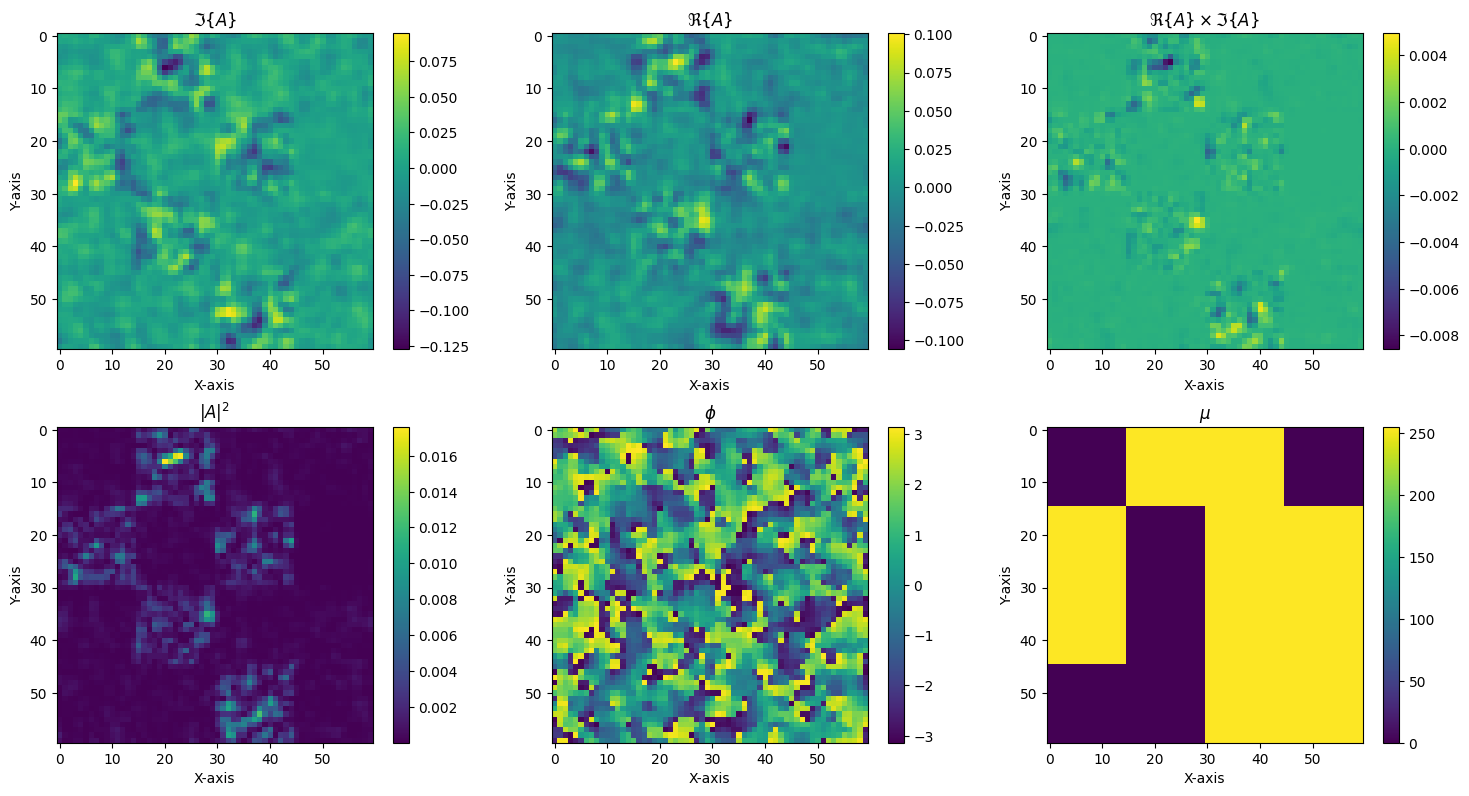

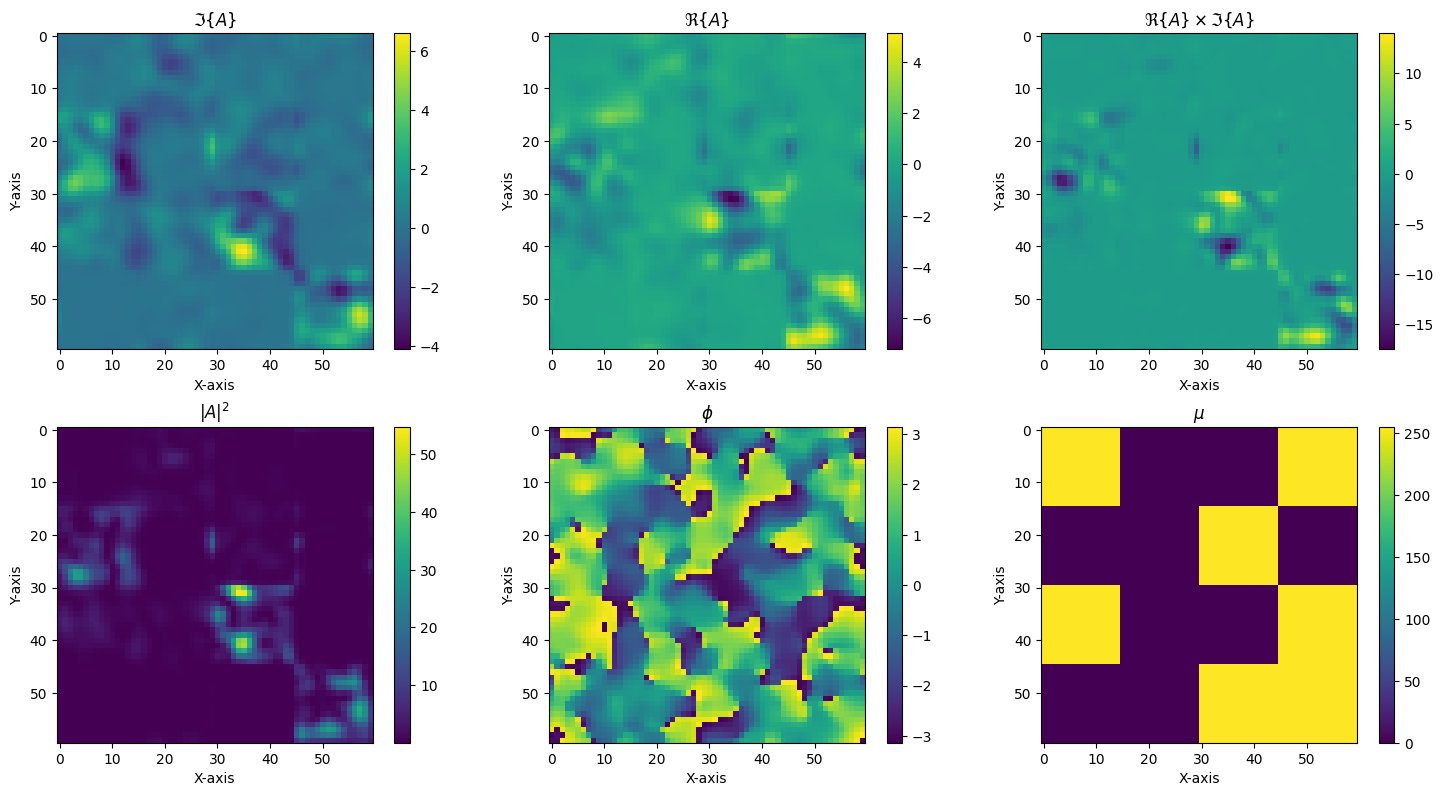

Running full training pipeline...
Setting up datasets...
Initializing PINN model...
Starting training...
=== Stage 1: Data-only Training ===
Epoch 0/5000, Data Loss: 3.862672
Epoch 10/5000, Data Loss: 0.460575
Epoch 20/5000, Data Loss: 0.303154
Epoch 30/5000, Data Loss: 0.052094
Epoch 40/5000, Data Loss: 0.028780
Epoch 50/5000, Data Loss: 0.023577
Epoch 60/5000, Data Loss: 0.013496
Epoch 70/5000, Data Loss: 0.011364
Epoch 80/5000, Data Loss: 0.026340
Epoch 90/5000, Data Loss: 0.037511
Epoch 100/5000, Data Loss: 0.009703
Epoch 110/5000, Data Loss: 0.011408
Epoch 120/5000, Data Loss: 0.025723
Epoch 130/5000, Data Loss: 0.010710
Epoch 140/5000, Data Loss: 0.007968
Epoch 150/5000, Data Loss: 0.007084
Epoch 160/5000, Data Loss: 0.005940
Epoch 170/5000, Data Loss: 0.006473
Epoch 180/5000, Data Loss: 0.009250
Epoch 190/5000, Data Loss: 0.480082
Epoch 200/5000, Data Loss: 0.017702
Epoch 210/5000, Data Loss: 0.008437
Epoch 220/5000, Data Loss: 0.006724
Epoch 230/5000, Data Loss: 0.017289
Epoch 

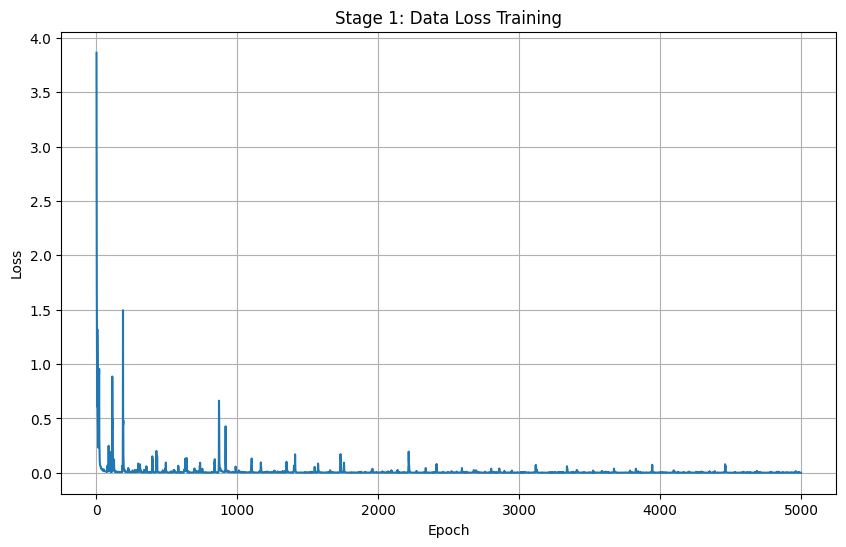


=== Stage 2: Physics-Informed Training ===
  Time Block Physics Loss - Min: Block 4 (3501.867676), Max: Block 1 (5570.808105)
New best model at epoch 0 with physics loss: 697.898137
Epoch 0/5000, Total Loss: 697.898494, Data Loss: 0.000359, Physics Loss: 697.898137
New best model at epoch 1 with physics loss: 215.220534
New best model at epoch 2 with physics loss: 92.471468
  Time Block Physics Loss - Min: Block 1 (728.464661), Max: Block 2 (864.572510)
Epoch 5/5000, Total Loss: 122.541748, Data Loss: 0.000427, Physics Loss: 122.541321
New best model at epoch 6 with physics loss: 67.293797
New best model at epoch 7 with physics loss: 37.770974
  Time Block Physics Loss - Min: Block 4 (338.368469), Max: Block 8 (419.413849)
Epoch 10/5000, Total Loss: 58.291102, Data Loss: 0.000155, Physics Loss: 58.290948
New best model at epoch 12 with physics loss: 21.009094
New best model at epoch 13 with physics loss: 15.205629
  Time Block Physics Loss - Min: Block 5 (167.115829), Max: Block 3 (20

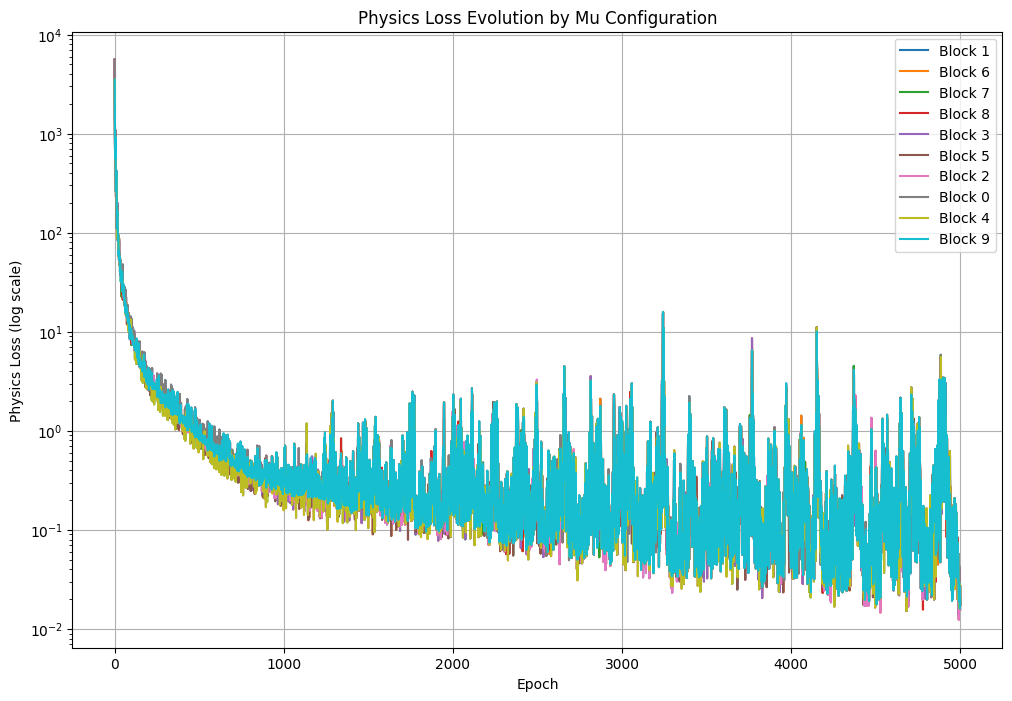

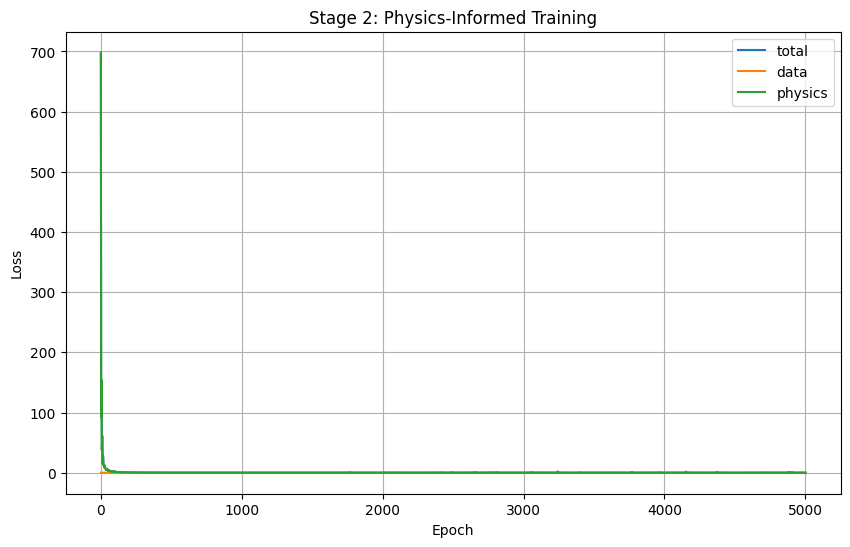

C:\Users\meloy\AppData\Local\Temp\ipykernel_12952\3902959120.py:221: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Generating predictions with best model...
Creating comparison video...


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Creating video:   0%|          | 0/100 [00:00<?, ?it/s]Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Creating video:   3%|▎         | 3/100 [00:00<00:09, 10.48it/s]Ignoring fixed y limits to fulfill fixed data aspect with adju

Video saved to ./outputs/videos\full_training_comparison.mp4

Physics Loss Analysis by Time Block (Unique Mu Configuration):
  Time Block 2: Physics Loss = 0.015747
  Time Block 5: Physics Loss = 0.015747
  Time Block 9: Physics Loss = 0.017560
  Time Block 8: Physics Loss = 0.017560
  Time Block 7: Physics Loss = 0.017560
  Time Block 0: Physics Loss = 0.017560
  Time Block 1: Physics Loss = 0.017560
  Time Block 4: Physics Loss = 0.017560
  Time Block 3: Physics Loss = 0.017560
  Time Block 6: Physics Loss = 0.017560


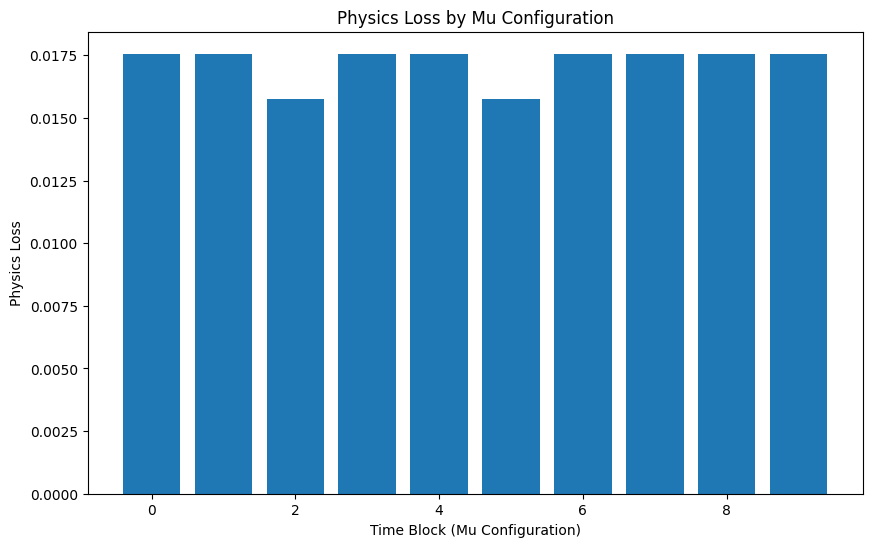

Comparing predictions...


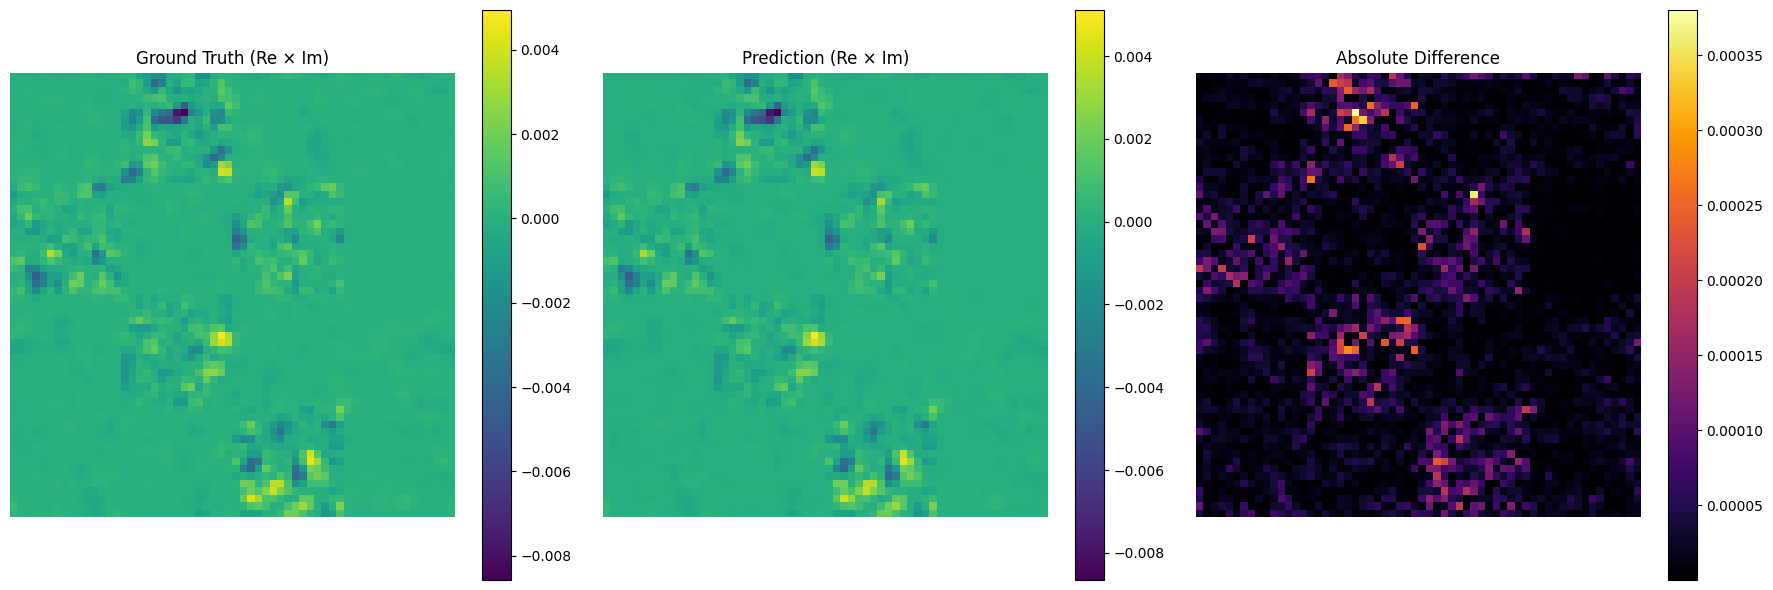

MSE: 0.000000
MAE: 0.000027
Max Error: 0.000380


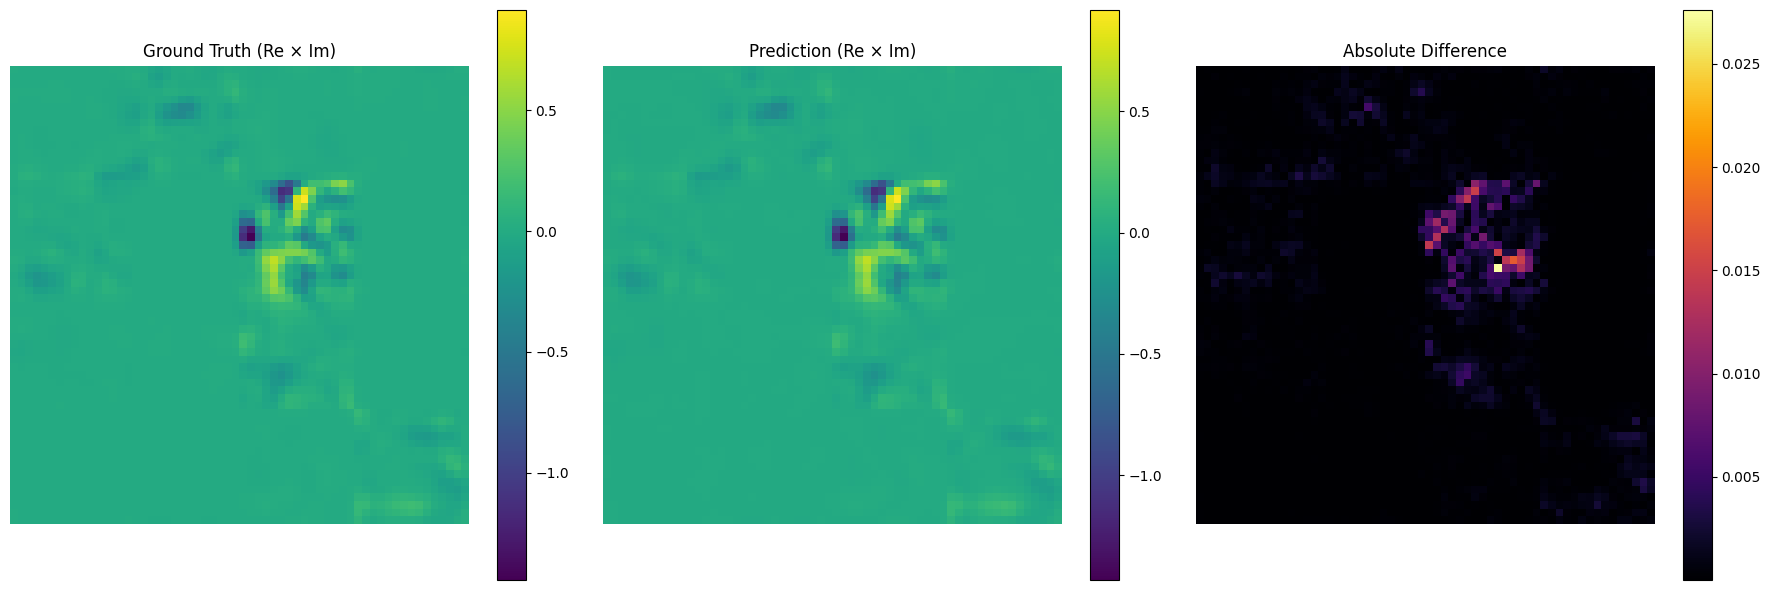

MSE: 0.000002
MAE: 0.000476
Max Error: 0.027610


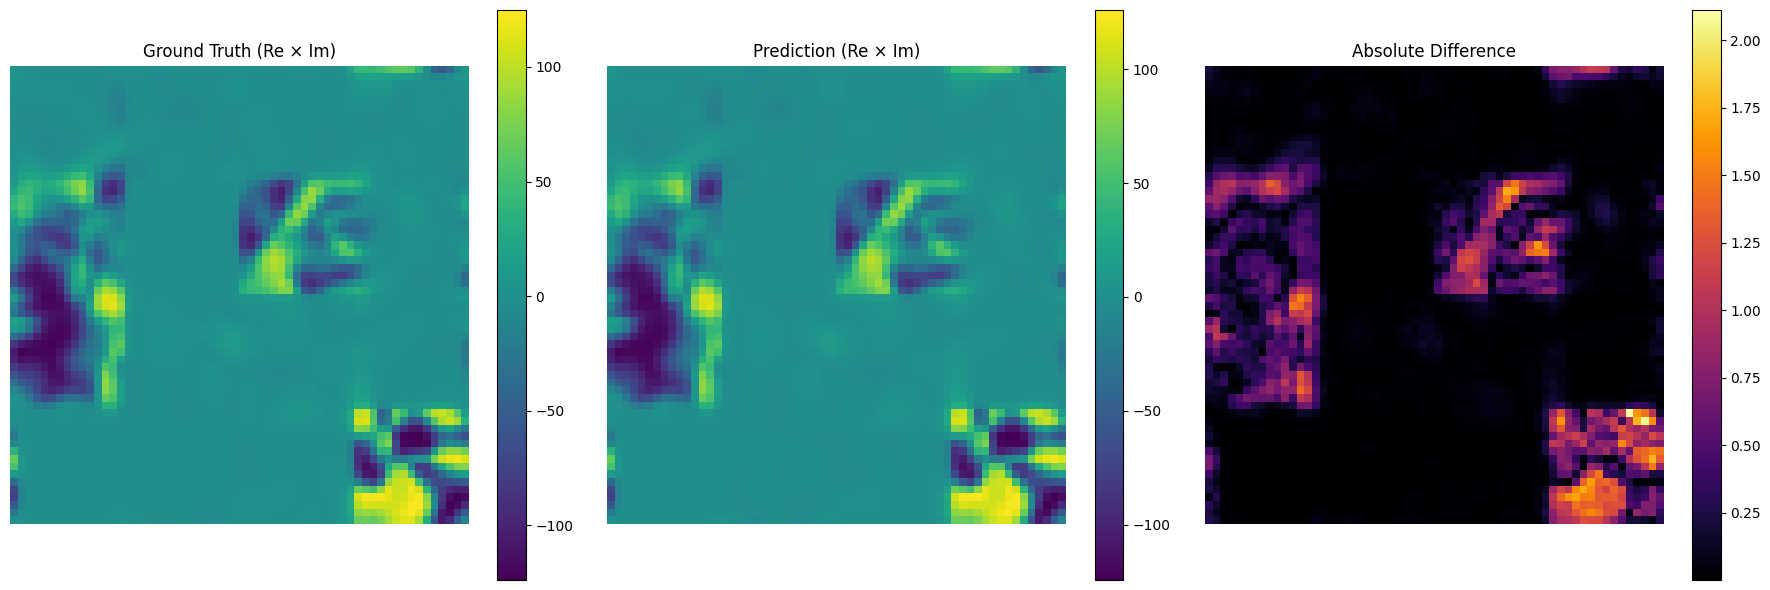

MSE: 0.129663
MAE: 0.171957
Max Error: 2.112564
Comparing mu parameter...


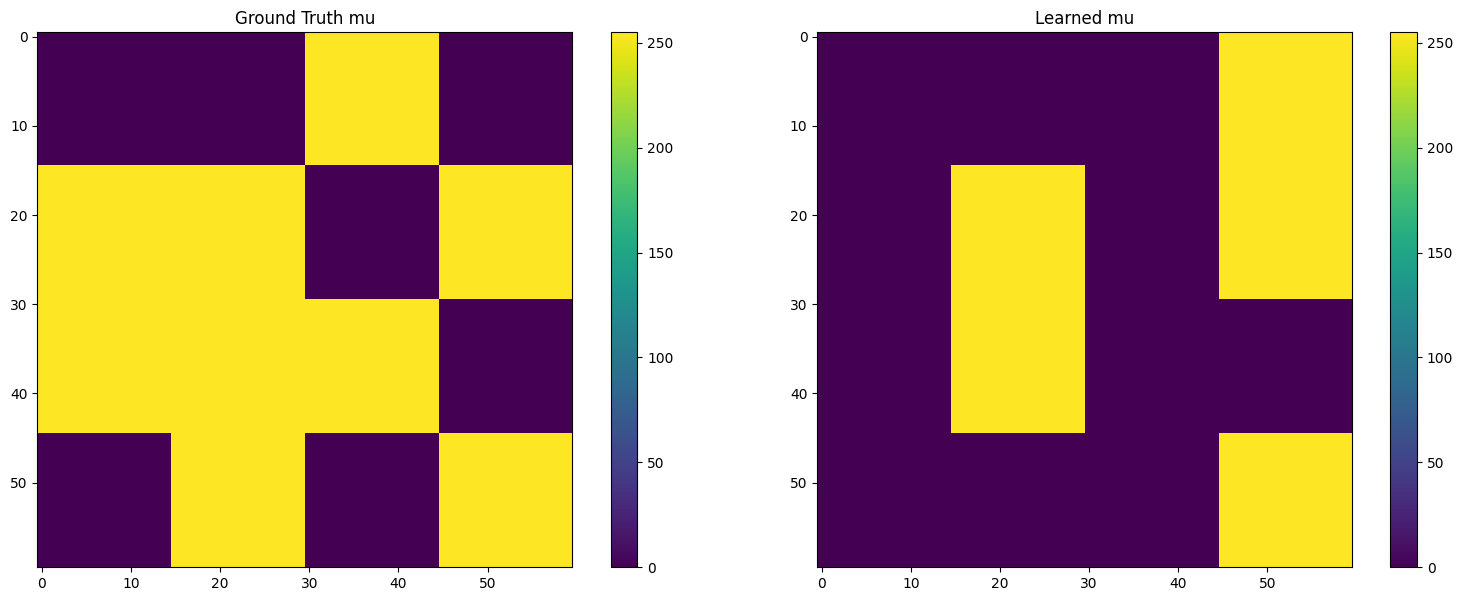

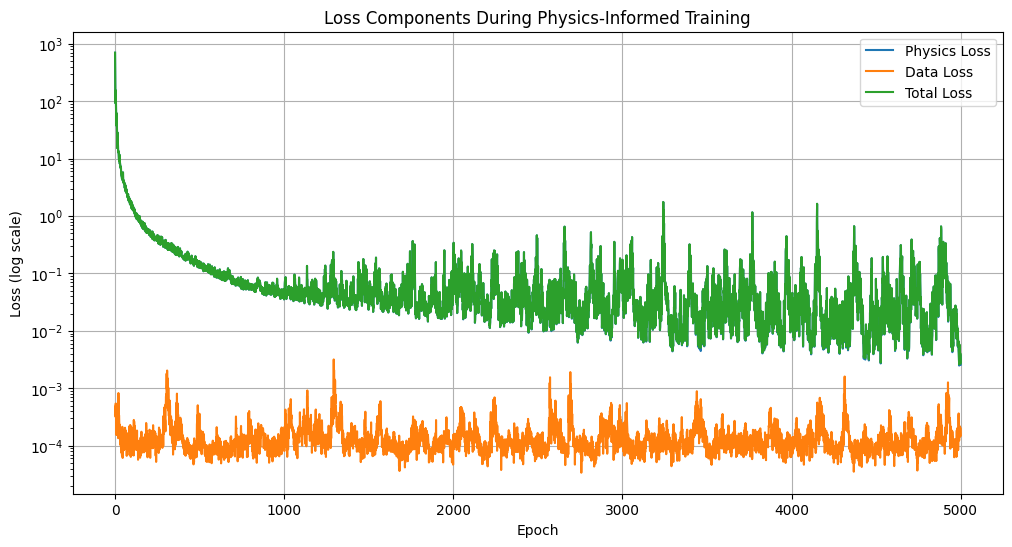

Calculating prediction metrics...


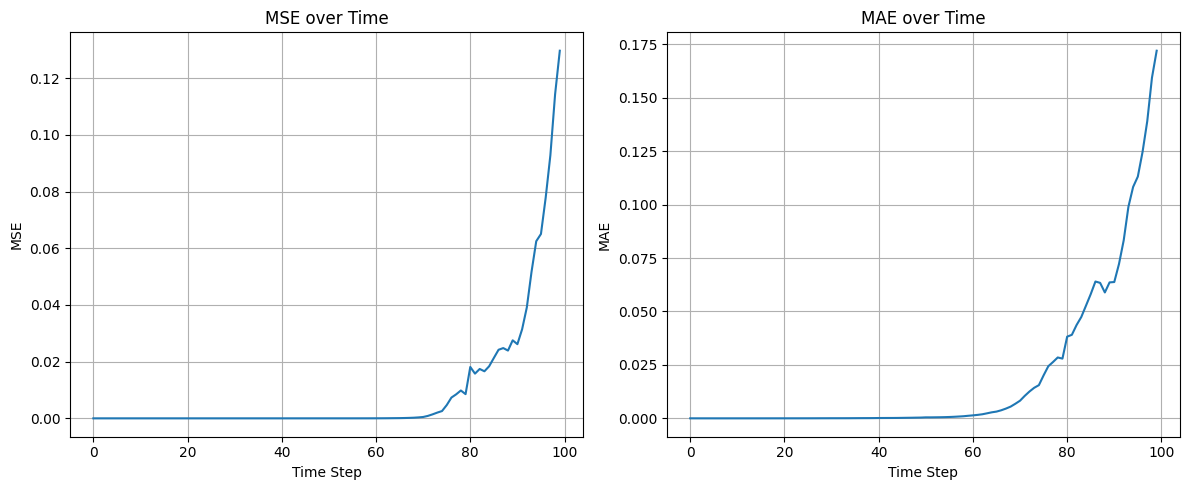

Average MSE: 0.009457
Average MAE: 0.018970
Saved final model and results to ./outputs\models\final_model.pt


In [12]:

# Plot sample frames to verify data
plot_state_and_myu(state=state, myu=myu, index=20)
plot_state_and_myu(state=state, myu=myu, index=70)

# %% [markdown]
# Now let's run the full training pipeline with both stages:

# %%
# Run the full training pipeline
print("Running full training pipeline...")
model, predictions, learned_mu, data_loss_history, physics_loss_history = run_full_training_pipeline(
    state=state,
    myu=myu,
    dt=0.0005,
    dx=0.15,
    dy=0.15,
    Nt_down=10,  # Temporal downsampling for mu
    Nx_down=4,   # Spatial downsampling for mu (x)
    Ny_down=4,   # Spatial downsampling for mu (y)
    data_epochs=5000,
    physics_epochs=5000,
    batch_size=8,
    device=device,
    lambda_physics=1.0
)

# %% [markdown]
# ## 9. Results Visualization and Analysis

# %%
# Compare predictions with ground truth
print("Comparing predictions...")

# Early frame
compare_predictions(state, predictions, index=20)

# Middle frame
compare_predictions(state, predictions, index=50)

# Late frame
compare_predictions(state, predictions, index=-1)

# Compare learned mu with ground truth mu
print("Comparing mu parameter...")
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.title("Ground Truth mu")
plt.imshow(myu[50], cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Learned mu")
plt.imshow(learned_mu[50], cmap='viridis')
plt.colorbar()

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'mu_comparison.png'))
plt.show()

# %% [markdown]
# ## 10. Additional Analysis and Experiments

# %%
# Plot the evolution of loss components during physics-informed training
physics_losses = []
data_losses = []
total_losses = []

for loss_dict in physics_loss_history:
    physics_losses.append(loss_dict['physics'])
    data_losses.append(loss_dict['data'])
    total_losses.append(loss_dict['total'])

plt.figure(figsize=(12, 6))
plt.semilogy(physics_losses, label='Physics Loss')
plt.semilogy(data_losses, label='Data Loss')
plt.semilogy(total_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Loss Components During Physics-Informed Training')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(plots_dir, 'loss_components.png'))
plt.show()

# Calculate quantitative metrics for predictions
print("Calculating prediction metrics...")
mse_values = []
mae_values = []

for i in range(len(state)):
    gt = state[i].real * state[i].imag
    pred = predictions[i].real * predictions[i].imag

    mse = np.mean((gt - pred) ** 2)
    mae = np.mean(np.abs(gt - pred))

    mse_values.append(mse)
    mae_values.append(mae)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mse_values)
plt.title('MSE over Time')
plt.xlabel('Time Step')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mae_values)
plt.title('MAE over Time')
plt.xlabel('Time Step')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'error_metrics.png'))
plt.show()

print(f"Average MSE: {np.mean(mse_values):.6f}")
print(f"Average MAE: {np.mean(mae_values):.6f}")

# Save the final model and predictions
final_model_path = os.path.join(models_dir, 'final_model.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'predictions': predictions,
    'learned_mu': learned_mu,
    'data_loss_history': data_loss_history,
    'physics_loss_history': physics_loss_history
}, final_model_path)

print(f"Saved final model and results to {final_model_path}")

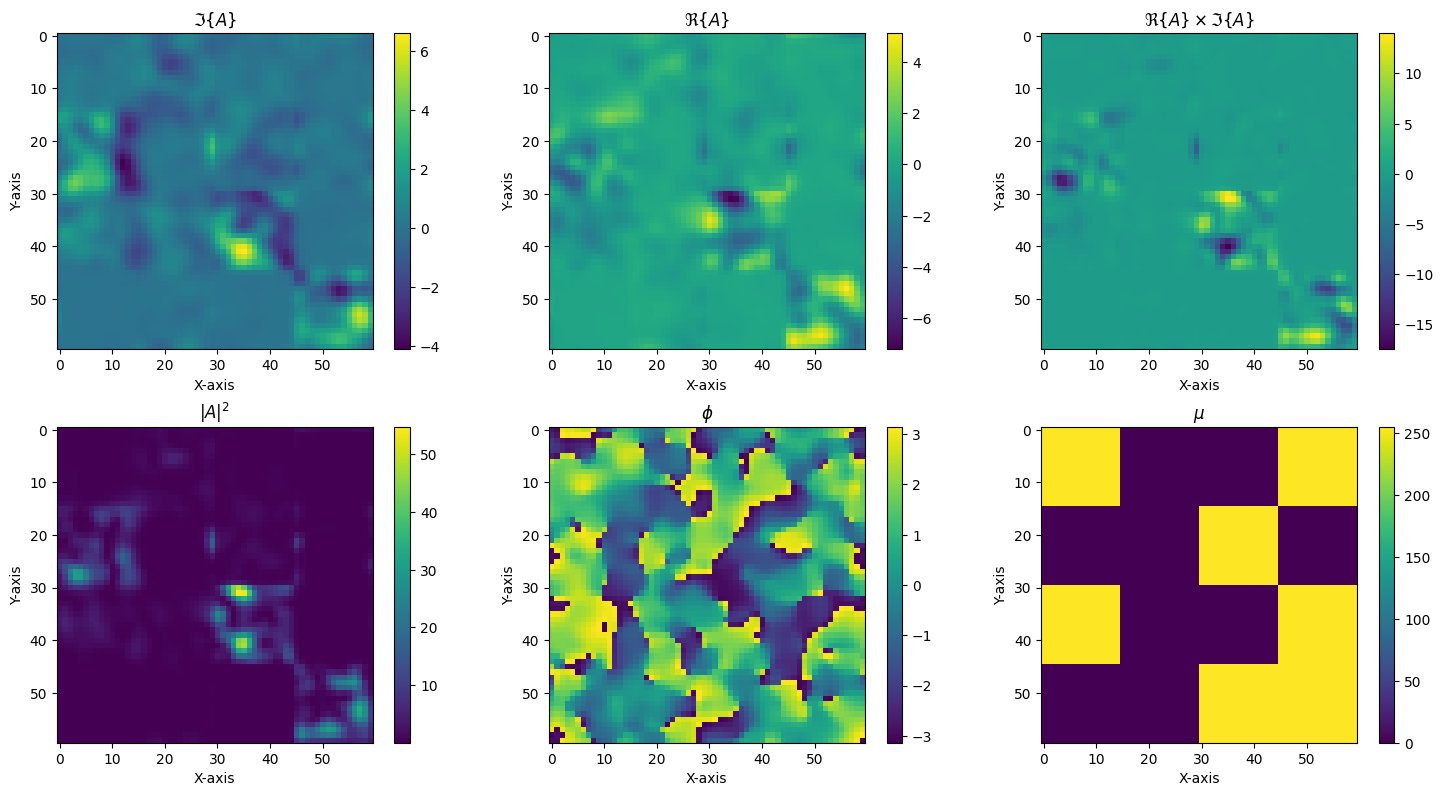

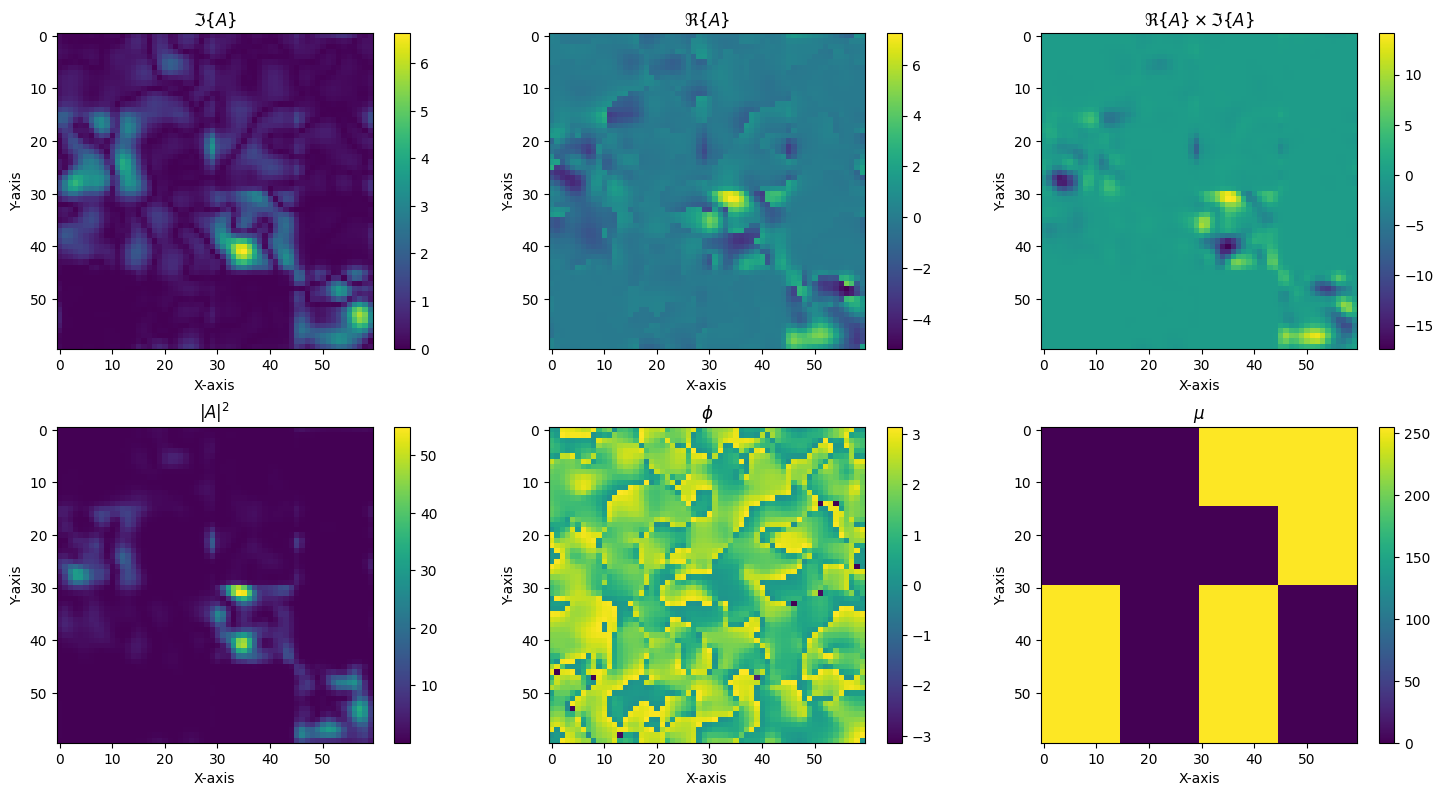

In [13]:
plot_state_and_myu(state=state, myu=myu, index=70)
plot_state_and_myu(state=predictions, myu=learned_mu, index=70)